# Training Log Analysis

## Prepare Data

Copy the training logs from the worker to the local machine

```bash
$ HOST=192.9.XXX.XX
$ scp "ubuntu@${HOST}:~/nano-gpt-ca-1/nano-gpt/train_*" . 
```

In [44]:
import pathlib

LOG_FILE_PATTERN = "train_*.log"

log_file = list(sorted(pathlib.Path(".").glob(LOG_FILE_PATTERN)))[-1]
print(log_file)
lines = log_file.read_text().splitlines()
print(lines[-1])


train_2025-04-06_01-53-23.log
train: step: 3149 | loss: 3.6304 | norm: 0.2765 | dt: 391.92ms | tok/sec: 1337738.02 | lr: 0.000577


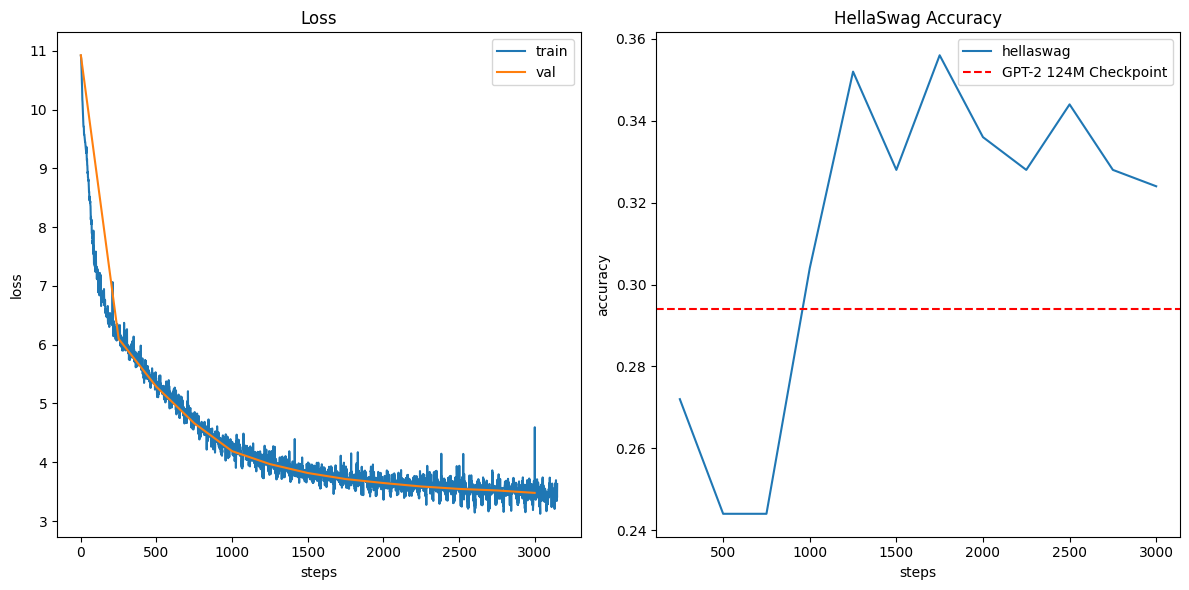

[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]
[0.272, 0.244, 0.244, 0.304, 0.352, 0.328, 0.356, 0.336, 0.328, 0.344, 0.328, 0.324]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def to_number(value: str) -> float | int:
    """Convert a string to a number, handling both float and int formats."""
    if value.endswith("ms"):
        return float(value[:-2])
    if "." in value:
        return float(value)
    return int(value)


def extract_fields(data: str) -> dict[str, str]:
    """Extract fields from a string formatted as 'key1:value1|key2:value2'."""
    return {
        parts[0].strip(): to_number(parts[1].strip())
        for part in data.split("|")
        if (parts := part.split(":", maxsplit=2))
    }


val_steps = []
val_loss = []
train_steps = []
train_loss = []
hellaswag_steps = []
hellaswag_accuracy = []
step = 0
for line in lines:
    if line.startswith("train:"):
        data = extract_fields(line[7:])
        step = int(data["step"])
        train_steps.append(step)
        train_loss.append(float(data["loss"]))
    elif line.startswith("val:"):
        data = extract_fields(line[5:])
        step = int(data["step"])
        val_steps.append(step)
        val_loss.append(float(data["loss"]))
    elif line.startswith("hellaswag:"):
        data = extract_fields(line[11:])
        hellaswag_steps.append(step)
        hellaswag_accuracy.append(float(data["accuracy"]))

GPT2_HELLASWAG_ACCURACY = 29.4 / 100.0
GPT3_HELLASWAG_ACCRUACY = 0.337

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label="train")
plt.plot(val_steps, val_loss, label="val")
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()

# Plot hellaswag accuracy
plt.subplot(1, 2, 2)
plt.plot(hellaswag_steps, hellaswag_accuracy, label="hellaswag")
plt.axhline(GPT2_HELLASWAG_ACCURACY, color="red", linestyle="--", label="GPT-2 124M Checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.title("HellaSwag Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

print(hellaswag_steps)
print(hellaswag_accuracy)